In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/KISTI

labels = ["moving", "operating", "drifting"]

Mounted at /content/drive
/content/drive/MyDrive/KISTI


# 1. EDA

In [3]:
from glob import glob

train_path = 'dataset_status/train/'
test_path = 'dataset_status/test/'

print("# of train:", len(glob(train_path + "*/*")))
print("# of test:", len(glob(test_path + "*/*")))

# of train: 1438
# of test: 158


In [4]:
for label in labels:
    train_imgs = (glob(train_path+label+"/*"))
    test_imgs = (glob(test_path+label+"/*"))

    print("[train/test] of", label, ":", str(len(train_imgs))+"/"+str(len(test_imgs)))

[train/test] of moving : 518/57
[train/test] of operating : 309/34
[train/test] of drifting : 611/67


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pandas as pd

def show_image(path, label, rows=2, cols=3):

    img_paths = glob(path + label +"/*")
    img_paths = img_paths[:rows*cols]
    print(img_paths)

    plt.rc('font', size=8)
    plt.figure(figsize=(15, 6))
    grid = gridspec.GridSpec(rows, cols)

    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

['dataset_status/train/moving/72. 타망 이동.jpg', 'dataset_status/train/moving/29. 범장망 이동.jpg', 'dataset_status/train/moving/102. 범장망 이동.jpg', 'dataset_status/train/moving/168. 타망 이동.jpg', 'dataset_status/train/moving/39. 타망 이동.jpg', 'dataset_status/train/moving/2. 범장망 이동.jpg']


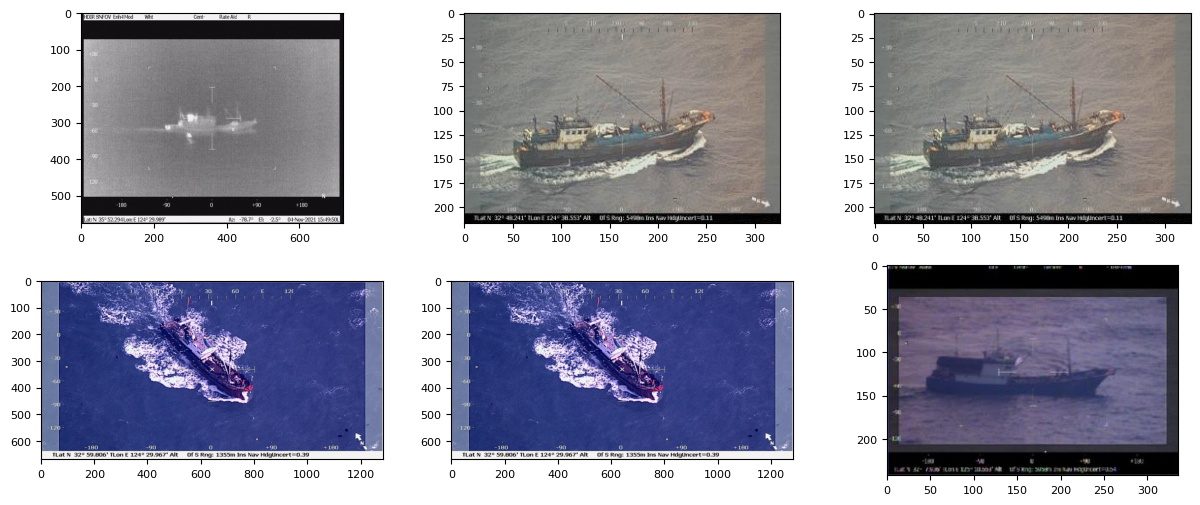

In [6]:
show_image(train_path, 'moving')

['dataset_status/train/operating/1. 유망 조업.jpg', 'dataset_status/train/operating/1. 범장망 조업.jpg', 'dataset_status/train/operating/2. 유망 조업.jpg', 'dataset_status/train/operating/2. 타망 조업.jpg', 'dataset_status/train/operating/3. 타망 조업.jpg', 'dataset_status/train/operating/5. 타망 조업.jpg']


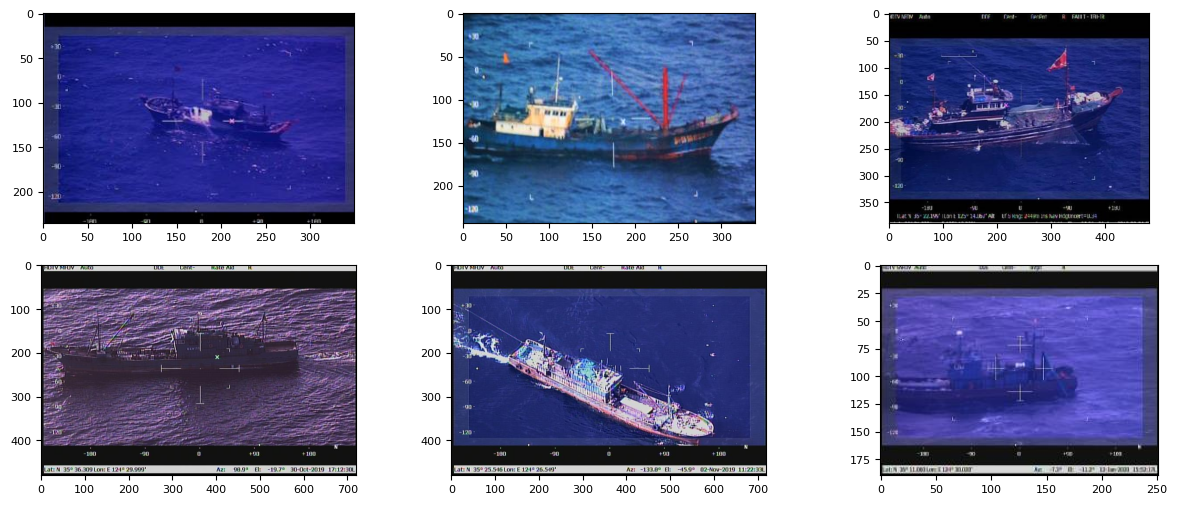

In [7]:
show_image(train_path, 'operating')

['dataset_status/train/drifting/51. 타망 표류.jpg', 'dataset_status/train/drifting/59. 타망 표류.jpg', 'dataset_status/train/drifting/302. 범장망 표류.jpg', 'dataset_status/train/drifting/45. 범장망 표류.jpg', 'dataset_status/train/drifting/44. 범장망 표류.jpg', 'dataset_status/train/drifting/3. 타망 표류.jpg']


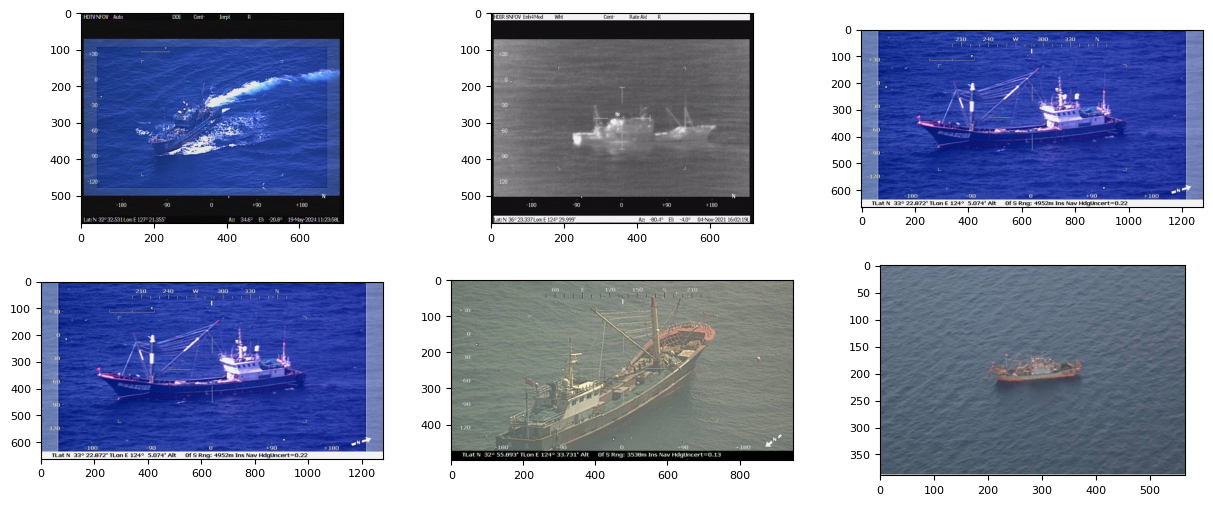

In [8]:
show_image(train_path, 'drifting')

# 2. Modeling

In [4]:
import torch
import random
import os

# fix seed
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

# get GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# check GPU
torch.cuda.is_available()

True

## 2.1. Augmentation

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = A.Compose([
    A.Resize(700, 900),
    A.Crop(x_min=0, y_min=100, x_max=900, y_max=600, p=1),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(700, 900),
    A.Crop(x_min=0, y_min=100, x_max=900, y_max=600, p=1),
    A.Normalize(),
    ToTensorV2()
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


## 2.2. DataLoader (with ImageFolder)

In [6]:
# albumentation과 ImageFolder(torchvision)을 결합하기 위해 Transforms 클래스 정의
# 기 정의된 클래스인 ImageFolder는 albumentation을 고려하고 짜여진 게 아니라, torchvision의 transforms 라이브러리를 기준으로 짜여졌음
# 관련해서 albuemntation은 item을 call할 때, "image = self.transform(image=image)['image']" 라는 구문을 사용함
# 그러므로, albumentation과 ImageFolder를 결합하기 위해서는 call 기능을 따로 호출해줘야 하고, 이것을 위해 클래스를 따로 정의함

# errors: keyerror: 'you have to pass data to augmentations as named arguments, for example: aug(image=image)'
# solution: https://stackoverflow.com/questions/69151052/using-imagefolder-with-albumentations-in-pytorch

class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [7]:
from torchvision.datasets import ImageFolder

datasets_train = ImageFolder(root=train_path, transform=Transforms(transforms=transform_train))
datasets_valid = ImageFolder(root=test_path, transform=Transforms(transforms=transform_test))

In [8]:
print("# of train:", len(datasets_train))
print("# of valid:", len(datasets_valid))

# of train: 1438
# of valid: 158


In [9]:
# multiprocessing
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# fix seed for Generator
g = torch.Generator()
g.manual_seed(0)

In [10]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, shuffle=True,
                         worker_init_fn=seed_worker, generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, shuffle=False,
                         worker_init_fn=seed_worker, generator=g, num_workers=2)

In [11]:
# len(dataset_train) / batch_size = len(loader_train)
print("# of dataset_train:", len(datasets_train))
print("# of loader_train:", len(loader_train))

# of dataset_train: 1438
# of loader_train: 180


## 2.3. Model Construction (EfficientNet-b7)

In [12]:
# !pip install efficientnet-pytorch==0.7.1

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=15b7c500c0264f9247b519e6372e06da182393dd71f0256b0da1474df408c9e2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [13]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=3)
model = model.to(device)

print("# of params in the model:", sum(param.numel() for param in model.parameters()))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 98.7MB/s]


Loaded pretrained weights for efficientnet-b7
# of params in the model: 63794643


In [14]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.001)

from transformers import get_cosine_schedule_with_warmup

epochs = 20
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

def train(model, loader_train, loader_valid, criterion, optimizer,
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):

    # initialize the loss
    valid_loss_min = np.inf

    for epoch in range(epochs):
        print(f'\tepoch [{epoch+1}/{epochs}] \n----------------------')

        # ==================== Phase: Train ====================
        model.train()
        epoch_train_loss = 0

        for images, labels in tqdm(loader_train):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() # add batch_loss to epoch_loss

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        print(f'\ttrain loss: {epoch_train_loss/len(loader_train):.4f}') # avg loss of an epoch

        # ==================== Phase: Valid ====================
        model.eval()
        epoch_valid_loss = 0
        preds_list = []
        true_list = []

        with torch.no_grad():

            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item() # add batch_loss to epoch_loss

                preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
                true = labels.cpu().numpy()

                preds_list.extend(preds)
                true_list.extend(true)

        print(f'\tvalid loss: {epoch_valid_loss/len(loader_valid):.4f}') # avg loss of an epoch

        # ==================== Check Metrics ====================
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list, average='macro')
        val_f1_score = f1_score(true_list, preds_list, average='macro')
        print(f'\taccuracy : {val_accuracy:.4f} / recall : {val_recall:.4f} / f1 score : {val_f1_score:.4f}')

        # ==================== Save Best Model ====================
        if epoch_valid_loss <= valid_loss_min:
            print(f'\tvalid loss decreases ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). save the model.')

            torch.save(model.state_dict(), save_file)
            valid_loss_min = epoch_valid_loss

    return torch.load(save_file)

# 3. Train

In [16]:
model_state_dict = train(model=model,
                        loader_train=loader_train,
                        loader_valid=loader_valid,
                        criterion=criterion,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        epochs=epochs,
                        save_file='Classifier_Status_EfficientNet-b7_AdamW_20epochs.pth')

	epoch [1/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.9751
	valid loss: 1.0960
	accuracy : 0.5949 / recall : 0.5026 / f1 score : 0.4721
	valid loss decreases (inf --> 21.9201). save the model.
	epoch [2/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.7795
	valid loss: 1.1284
	accuracy : 0.5633 / recall : 0.4930 / f1 score : 0.4334
	epoch [3/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.7787
	valid loss: 1.1402
	accuracy : 0.6392 / recall : 0.5484 / f1 score : 0.5181
	epoch [4/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.7913
	valid loss: 0.9056
	accuracy : 0.6203 / recall : 0.5533 / f1 score : 0.5526
	valid loss decreases (21.9201 --> 18.1125). save the model.
	epoch [5/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.7188
	valid loss: 1.1349
	accuracy : 0.5886 / recall : 0.4920 / f1 score : 0.4579
	epoch [6/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.6457
	valid loss: 1.1123
	accuracy : 0.6519 / recall : 0.5812 / f1 score : 0.5893
	epoch [7/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.6061
	valid loss: 0.7131
	accuracy : 0.6709 / recall : 0.6768 / f1 score : 0.6618
	valid loss decreases (18.1125 --> 14.2628). save the model.
	epoch [8/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.5659
	valid loss: 0.9611
	accuracy : 0.7089 / recall : 0.6268 / f1 score : 0.6250
	epoch [9/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.4788
	valid loss: 0.6387
	accuracy : 0.7785 / recall : 0.7276 / f1 score : 0.7435
	valid loss decreases (14.2628 --> 12.7744). save the model.
	epoch [10/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.3890
	valid loss: 0.8003
	accuracy : 0.7342 / recall : 0.7301 / f1 score : 0.7188
	epoch [11/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.3256
	valid loss: 0.6477
	accuracy : 0.7911 / recall : 0.7463 / f1 score : 0.7543
	epoch [12/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.2689
	valid loss: 0.7632
	accuracy : 0.8165 / recall : 0.7609 / f1 score : 0.7796
	epoch [13/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.2193
	valid loss: 0.5765
	accuracy : 0.8101 / recall : 0.7762 / f1 score : 0.7831
	valid loss decreases (12.7744 --> 11.5292). save the model.
	epoch [14/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.1938
	valid loss: 0.5927
	accuracy : 0.8418 / recall : 0.8059 / f1 score : 0.8180
	epoch [15/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.1199
	valid loss: 0.5548
	accuracy : 0.8354 / recall : 0.7881 / f1 score : 0.8015
	valid loss decreases (11.5292 --> 11.0968). save the model.
	epoch [16/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.1014
	valid loss: 0.6785
	accuracy : 0.8228 / recall : 0.7734 / f1 score : 0.7881
	epoch [17/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.1081
	valid loss: 0.6412
	accuracy : 0.8165 / recall : 0.7772 / f1 score : 0.7886
	epoch [18/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.0919
	valid loss: 0.6260
	accuracy : 0.8038 / recall : 0.7624 / f1 score : 0.7724
	epoch [19/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.0782
	valid loss: 0.6512
	accuracy : 0.8038 / recall : 0.7624 / f1 score : 0.7702
	epoch [20/20] 
----------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	train loss: 0.0718
	valid loss: 0.6531
	accuracy : 0.8165 / recall : 0.7724 / f1 score : 0.7828


<ipython-input-15-bafe2bfeb637>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(save_file)
